# Harris County Home Price Estimations


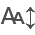

In [1]:
import os
from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itables import init_notebook_mode, show
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from load_to_dataframe import load_data_frame

init_notebook_mode(all_interactive=True)

In [2]:
df = load_data_frame()

In [3]:
# Define the haversine function
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    R = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(single_point[0], single_point[1], row["latitude"], row["longitude"]),
    axis=1,
)

In [4]:
df["assessed_per_sqft"] = df["assessed_per_sqft"].replace([np.inf, -np.inf], np.nan)

In [5]:
show(df)

In [6]:
df["assessed_per_sqft"].describe()

count    1.115156e+06
mean     1.824132e+02
std      3.866353e+02
min      1.785714e+00
25%      1.248015e+02
50%      1.440565e+02
75%      1.728197e+02
max      3.432030e+04
Name: assessed_per_sqft, dtype: float64

# Reduce data set to manageable size
The current data set is over 1.1M rows. This will take days to train a model on a regular computer. 

The help reduce the dataset I will start by removing all homes where the im_sq_ft is less than 50, since it is not really livable when there are not even 50 square feet of space.

The dataset will be reduced even more to only include homes that are assessed less than or equal to 2 million dollars.


In [7]:
df = df[df["assessed_val"] <= 2000000]

In [8]:
y_market = df["tot_mkt_val"]
y = df["assessed_val"]
y_bld_val = df["bld_val"]
y_per_sqft = df["assessed_per_sqft"]

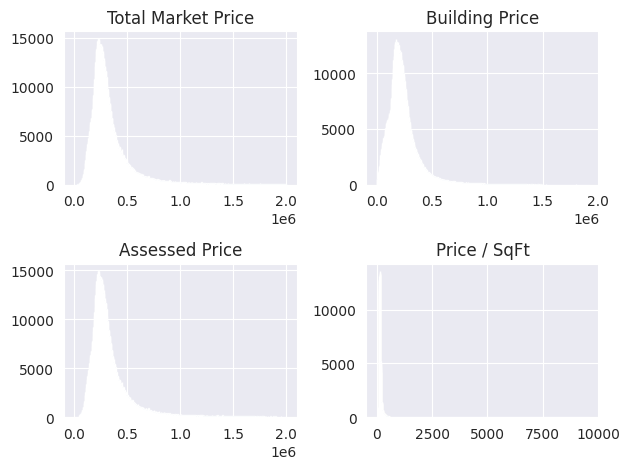

In [9]:
fig, axs = plt.subplots(2, 2)

# Total Market Price
axs[0, 0].hist(y_market, bins="auto")
axs[0, 0].set_title("Total Market Price")

# Assessed values
axs[1, 0].hist(y, bins="auto")
axs[1, 0].set_title("Assessed Price")

# Building value
axs[0, 1].hist(y_bld_val, bins="auto")
axs[0, 1].set_title("Building Price")

# Price per square foot
axs[1, 1].hist(y_per_sqft, bins="auto")
axs[1, 1].set_title("Price / SqFt")

fig.tight_layout()
plt.show()

In [10]:
# # IQR
# Q1 = df["assessed_val"].quantile(0.25)
# Q3 = df["assessed_val"].quantile(0.75)
# IQR = Q3 - Q1

# lower_iqr = Q1 - 1.5 * IQR
# upper_iqr = Q3 + 1.5 * IQR
# print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

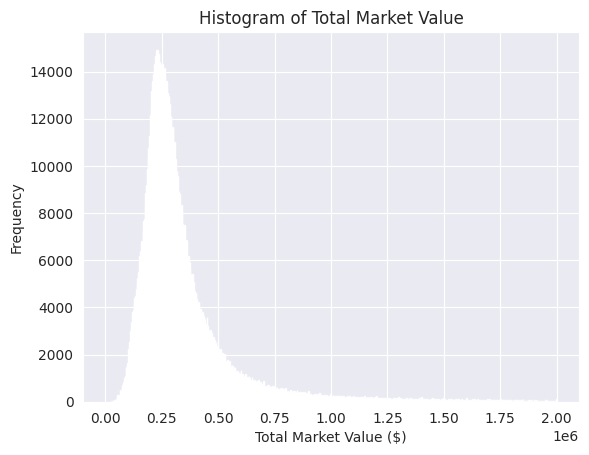

In [11]:
plt.hist(df["tot_mkt_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Total Market Value")
plt.show()

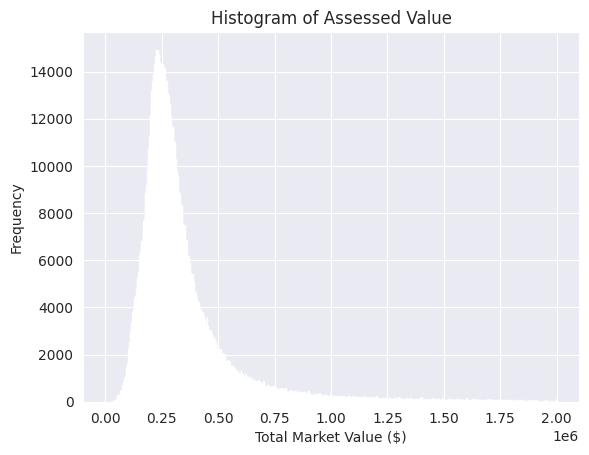

In [12]:
plt.hist(df["assessed_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Assessed Value")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model.

In [13]:
sample_df = df.sample(n=5000, random_state=42)
show(sample_df)

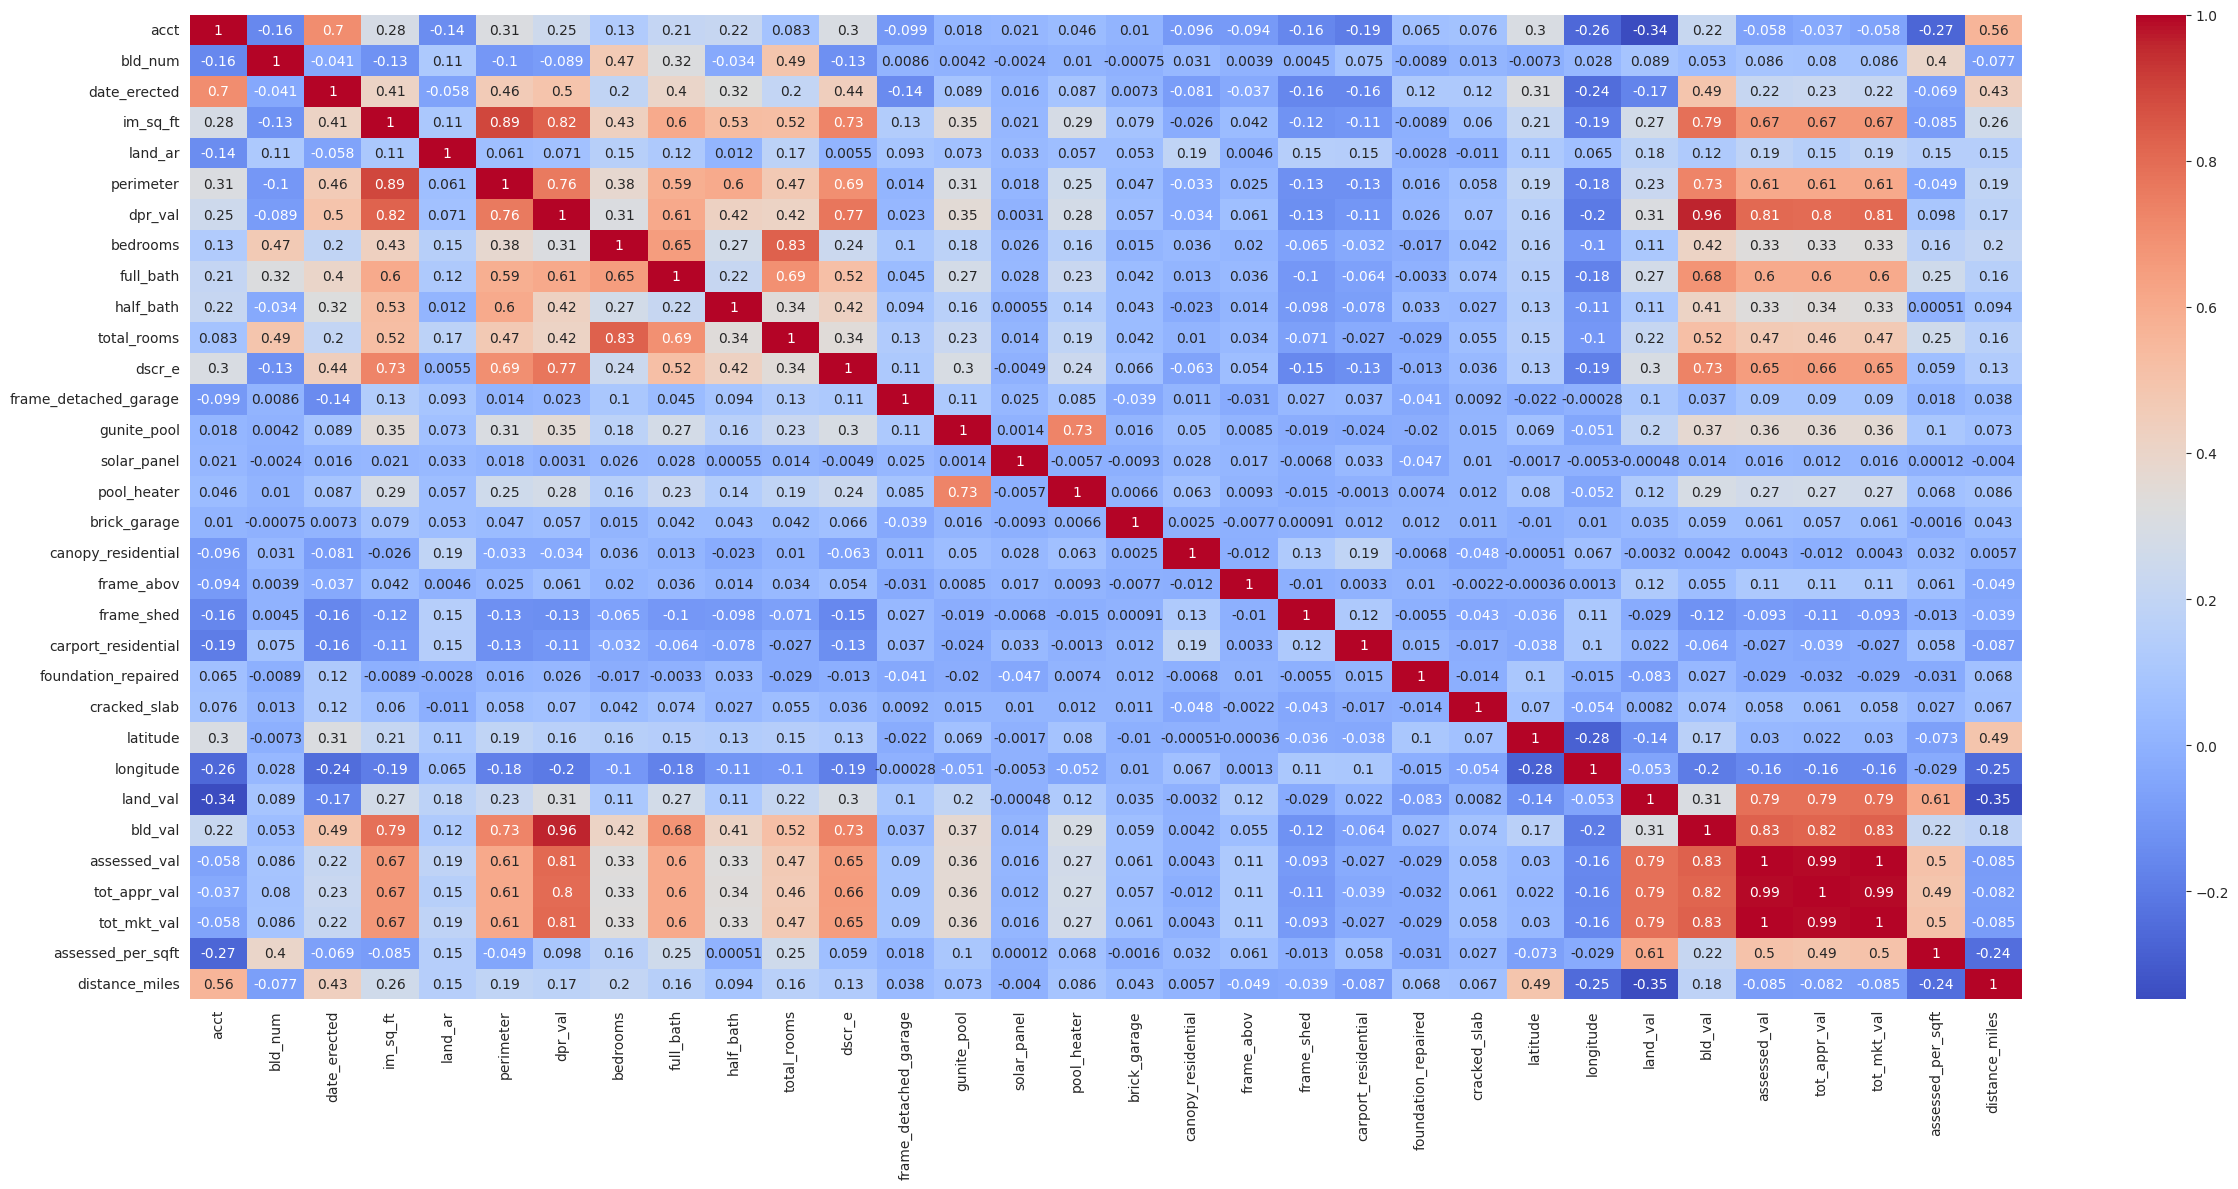

In [14]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

In [15]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y = sample_df["assessed_val"]
print(f"There are {X.shape[1] + 1} features in total.")

There are 23 features in total.


# Train, Test, Split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [65]:
etc = ExtraTreesRegressor(random_state=42, n_jobs=4)
param_grid = {
    "n_estimators": [4000,5000],
    "min_samples_leaf": [1],
    "max_features": [X.shape[1] + 1],
    "criterion": ["friedman_mse"],
    "warm_start": [True, False],
}
etc_cv = GridSearchCV(etc, param_grid, cv=5, n_jobs=4, scoring="r2")
etc_cv.fit(x_train, y_train)

/home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(n_jobs=4, random_state=42),
             n_jobs=4,
             param_grid={'criterion': ['friedman_mse'], 'max_features': [23],
                         'min_samples_leaf': [1], 'n_estimators': [4000, 5000],
                         'warm_start': [True, False]},
             scoring='r2')

In [66]:
etc_cv.best_params_

{'criterion': 'friedman_mse',
 'max_features': 23,
 'min_samples_leaf': 1,
 'n_estimators': 4000,
 'warm_start': True}

In [67]:
etc_cv.best_score_

np.float64(0.8194298805939961)

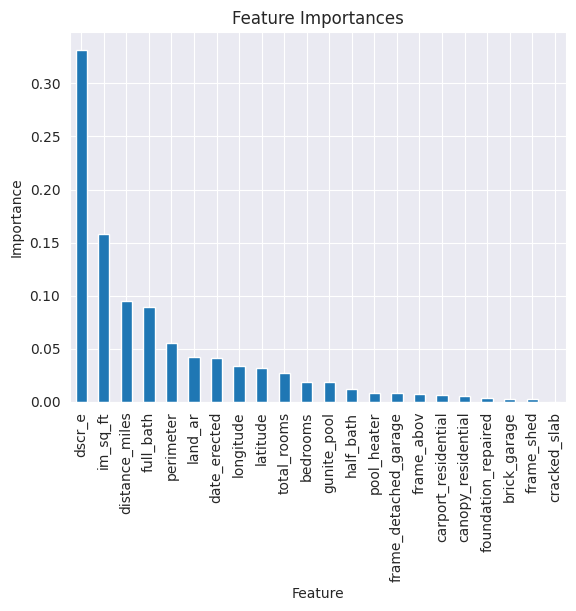

In [68]:
feature_names = [f"{i}" for i in X.columns]
best_model = etc_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graph the importance of the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()


In [69]:
etc_cv_results = pd.DataFrame(etc_cv.cv_results_)
etc_cv_results["param_n_estimators"] = etc_cv_results["param_n_estimators"].astype(
    "category"
)
etc_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      40.466236      1.293173         1.393585        0.313153   
1      42.137409      0.407712         1.280140        0.315461   
2      50.905599      0.739903         2.135887        0.088003   
3      49.914397      2.760331         1.660709        0.799733   

  param_criterion  param_max_features  param_min_samples_leaf  \
0    friedman_mse                  23                       1   
1    friedman_mse                  23                       1   
2    friedman_mse                  23                       1   
3    friedman_mse                  23                       1   

  param_n_estimators  param_warm_start  \
0               4000              True   
1               4000             False   
2               5000              True   
3               5000             False   

                                              params  split0_test_score  \
0  {'criterion': 'friedman_mse', 'max_features': ...           0.827347   
1  {'criterion': 'friedman_mse', 'max_features': ...           0.827347   
2  {'criterion': 'friedman_mse', 'max_features': ...           0.826432   
3  {'criterion': 'friedman_mse', 'max_features': ...           0.826432   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.825190           0.808558           0.835583           0.800471   
1           0.825190           0.808558           0.835583           0.800471   
2           0.825522           0.808296           0.835900           0.800535   
3           0.825522           0.808296           0.835900           0.800535   

   mean_test_score  std_test_score  rank_test_score  
0         0.819430        0.012918                1  
1         0.819430        0.012918                1  
2         0.819337        0.012949                3  
3         0.819337        0.012949                3

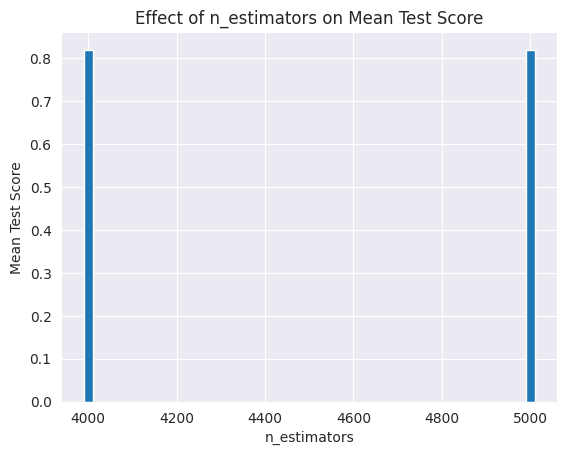

In [70]:
plt.bar(
    etc_cv_results["param_n_estimators"], etc_cv_results["mean_test_score"], width=20
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of n_estimators on Mean Test Score")
plt.show()

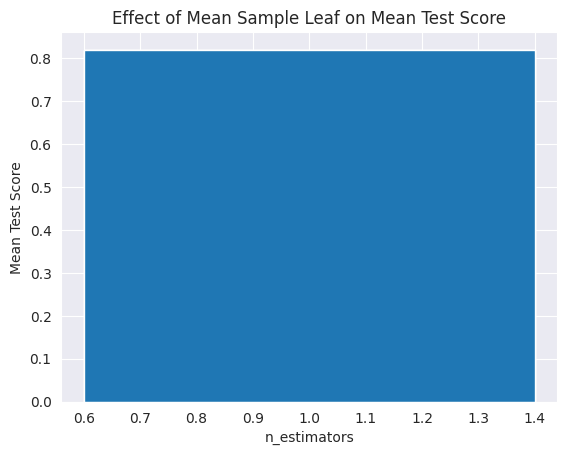

In [71]:
plt.bar(
    etc_cv_results["param_min_samples_leaf"],
    etc_cv_results["mean_test_score"],
    width=0.8,
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of Mean Sample Leaf on Mean Test Score")
plt.show()

## Analysis of testing data

In [72]:
etc_pred = etc_cv.predict(x_test)
etc_mae = mean_absolute_error(y_test, etc_pred)
etc_mse = mean_squared_error(y_test, etc_pred)
etc_r2 = r2_score(y_test, etc_pred)
print(f"MAE: {etc_mae}\nMSE: {etc_mse}\nR Squared: {etc_r2}\n")

MAE: 52199.311786
MSE: 10136657830.960339
R Squared: 0.850665999211558



In [73]:
# Define the folder name
folder_name = "Models"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d")

joblib.dump(etc_cv, f"Models/etc_{formatted_date}.pkl")

Folder 'Models' already exists.


['Models/etc_20241126.pkl']

# Residual Analysis

In [74]:
actual = y_test.to_list()
predicted = etc_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

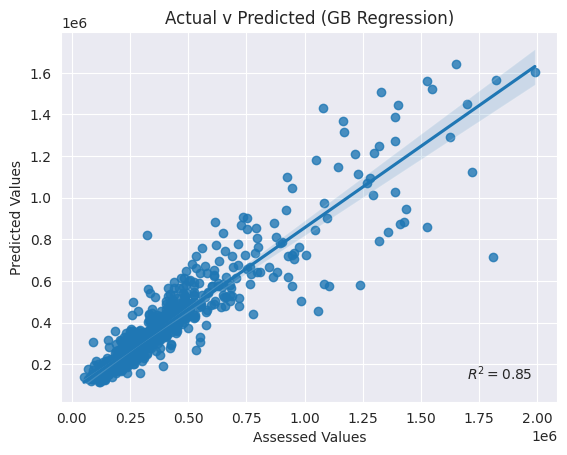

In [75]:
sns.regplot(etc_residuals, x="actual", y="predicted")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (GB Regression)')

plt.text(0.95, 0.05, f"$R^2 = {etc_r2:.2f}$",
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10)
plt.show()

## Gradient Boosting Regressor

The assessed values are not normally distributed, but are skewed right. They will be log transformed and the predicted values will be expectationaled back to assess the residuals.

In [29]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [3000, 4000],
    "learning_rate": [0.005, 0.0005],
    "max_depth": [5],
    "min_samples_split": [1, 3, 5, 7, 9],
    "min_samples_leaf": [1],
    "max_features": [(X.shape[1] + 1)],
    "warm_start": [True],
    "criterion": ["friedman_mse"],
}
gbr_cv = GridSearchCV(gbr, param_grid, cv=5, n_jobs=4, scoring="r2")

In [30]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

/home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/specter/PycharmProjects/HouseProtestValues/.venv

In [31]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 49111.78157569324
MSE: 8958309460.488703
R Squared: 0.8680255154761412



In [32]:
gbr_cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.005,
 'max_depth': 5,
 'max_features': 23,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 4000,
 'warm_start': True}

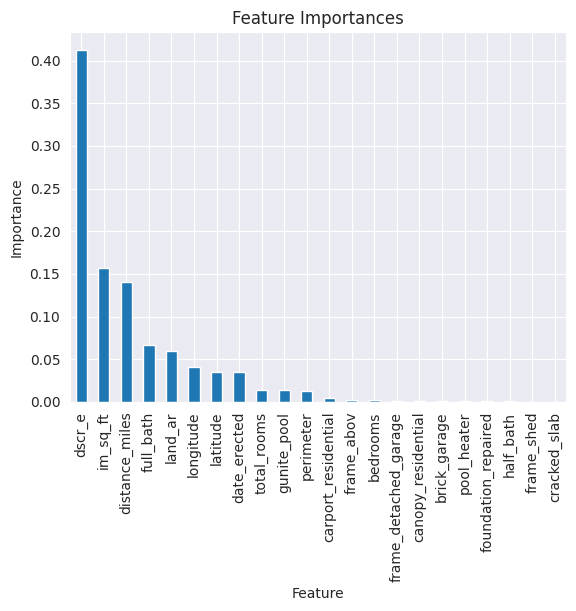

In [33]:
feature_names = [f"{i}" for i in X.columns]
best_model = gbr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graph the importance of the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [34]:
gbr_cv.best_score_

np.float64(0.8695416883940343)

In [35]:
joblib.dump(gbr_cv, "Models/gbr.pkl")

# load
# joblib.load('gbr.pkl')

['Models/gbr.pkl']

In [36]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

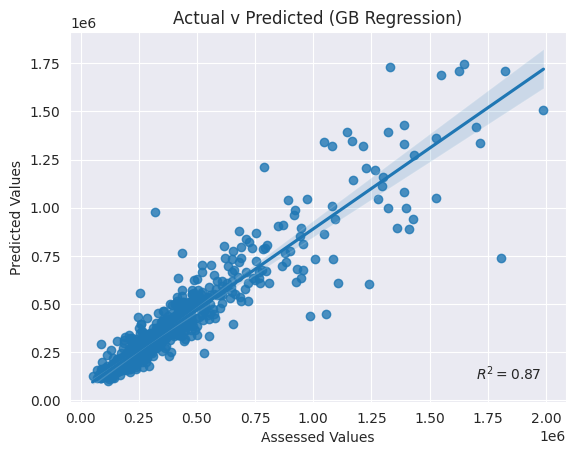

In [37]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (GB Regression)')

plt.text(0.95, 0.05, f"$R^2 = {gbr_r2:.2f}$",
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10)
plt.show()

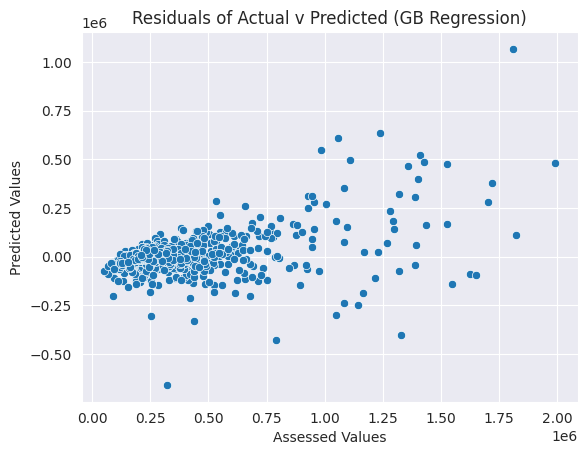

In [38]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel('Assessed Values')
plt.ylabel('Predicted Values')
plt.title('Residuals of Actual v Predicted (GB Regression)')
plt.show()

## XGBoost

In [48]:
import xgboost as xgb

# # Load the dataset (replace with your actual data source)
# # Example dataset: 'housing_data.csv' with features like 'sqft', 'bedrooms', 'bathrooms', etc., and target 'price'
# # df = pd.read_csv('housing_data.csv')
# # Example dataset creation for demonstration:
# data = {
#     'sqft': [1500, 2000, 2500, 3000, 3500],
#     'bedrooms': [3, 4, 3, 5, 4],
#     'bathrooms': [2, 3, 2, 4, 3],
#     'price': [300000, 400000, 350000, 500000, 450000]
# }
# df = pd.DataFrame(data)
#
# # Define features (X) and target (y)
# X = df.drop('price', axis=1)
# y = df['price']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix, the data structure used by XGBoost
train_dmatrix = xgb.DMatrix(x_train, label=y_train)
test_dmatrix = xgb.DMatrix(x_test, label=y_test)

# Set parameters for the XGBoost model
params = {

    'objective': 'reg:squarederror',  # For regression
    'max_depth': 10,
    'eta': 0.01,  # Learning rate
    'seed': 42
}

# Train the model
xg_reg = xgb.train(params, train_dmatrix, num_boost_round=100)

# Make predictions
predictions = xg_reg.predict(test_dmatrix)

# Evaluate the model
r_square = r2_score(y_test, predictions)
print(f"R-squared fit: {r_square}")

XGBoostError: [17:59:05] /workspace/src/objective/objective.cc:31: Unknown objective function: `reg:rmse`
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:gamma
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x73254e22dcbc]
  [bt] (1) /home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x707401) [0x73254e707401]
  [bt] (2) /home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5bf6e1) [0x73254e5bf6e1]
  [bt] (3) /home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5c957b) [0x73254e5c957b]
  [bt] (4) /home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5caf4d) [0x73254e5caf4d]
  [bt] (5) /home/specter/PycharmProjects/HouseProtestValues/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x73254e13752f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7b16) [0x732704daab16]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x43ef) [0x732704da73ef]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(ffi_call+0x12e) [0x732704daa0be]



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

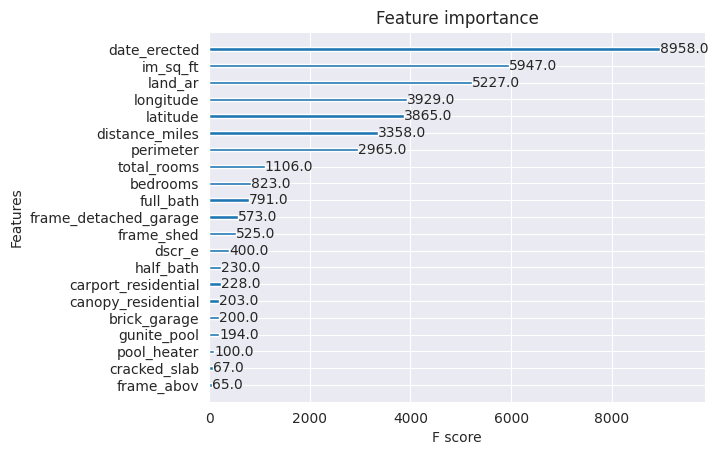

In [46]:

# Feature importance (optional visualization)
xgb.plot_importance(xg_reg)